<h1><center>Auxiliar 1 </center></h1>

<center><strong>CC6205: Procesamiento de Lenguaje Natural - Otoño 2022</strong></center>


## 📚 Objetivos de la clase 📚

El objetivo principal de esta clase es introducirlos a la clasificación de texto en NLP. 
Para esto, implementaremos varios modelos de clasificación destinados a **predecir la categoría asociada a noticias de la radio biobio**.

Utilizaremos los siguientes elementos, que fueron descritos en las cátedras:

- Tokenización, Stemming, Lematización y eliminación de Stop Words.
- Bag of Words.
- Clasificador de Bayes.
- Logistic regression.

Las librerías que vamos a utilizar son las siguientes:

- Pandas
- Scikit-Learn
- Spacy
- NLTK

Además, pueden utilizar cualquier parte del código que les parezca prudente para la competencia 1 (que también es de clasificación de texto! 😊).



## Configuraciones iniciales. 

En primer lugar, vamos a descargar un modelo estadístico en Español que nos servirá como tokenizador para nuestros documentos. 

In [8]:
!python -m spacy download es_core_news_sm

/home/tridimensional/u/dcc/noveno/nlp/nlp/bin/python: No module named spacy


Luego de ejecutar esta celda, deben ir a Entorno de ejecución > Reiniciar entorno de ejecución. Desconozco la razón pero hay un problema de compatibilidad entre el entorno de Google Colab y las dependencias de Spacy. Cuando esté el entorno conectado nuevamente, pueden seguir con los siguientes bloques de código.

In [2]:
import spacy

# Guardamos en la variable nlp el modelo para realizar la tokenización.
nlp = spacy.load("es_core_news_sm", disable = ['ner', 'parser', 'tagger'])

example = 'Este es un ejemplo del tokenizador!'
spacy_tokens = [token for token in nlp(example)]
spacy_tokens

ModuleNotFoundError: No module named 'spacy'

Ahora importamos todas las librerías que usaremos en esta auxiliar. Aún no es necesario que entiendan lo que hacen estas librerías, clases y funciones importadas ya que lo veremos ha medida que avancemos en el auxiliar.

In [ ]:
import pandas as pd    
import seaborn as sns
import spacy
import nltk
from sklearn.feature_extraction.text import CountVectorizer  
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from spacy.lang.es.stop_words import STOP_WORDS

## Clasificación de Texto 


### ¿Qué es la clasificación de texto?

En palabras simples, la clasificación de texto es una tarea de NLP que busca clasificar el contenido de un texto en categorías pre-definidas. Antes de dar una definición formal, veamos algunos ejemplos. [Fuente](https://kavita-ganesan.com/5-real-world-examples-of-text-classification/#.YHOvqR8zbIU)

    




1. **Detección de SPAM**. 

<center><img src="https://i1.wp.com/www.opinosis-analytics.com/wp-content/uploads/2020/08/document_classification.png?resize=872%2C436&ssl=1" width="400"></center>

2. **Detección de discursos de odio**.

<center><img src=https://i1.wp.com/www.opinosis-analytics.com/wp-content/uploads/2020/08/hate_speech-1.png?resize=410%2C193&ssl=1" width="400"></center>

3. **Sistema de ayuda a partir de información en redes sociales**.

<center><img src=https://cdn-images-1.medium.com/max/800/1*0DutkCqj51mgZ1xQp7tChA.png width="400"></center>

4. **Análisis de reviews de películas y series**.

<center><img src=https://raw.githubusercontent.com/dccuchile/CC6205/master/tutorials/recursos/limpiapiscinas.PNG width="650"></center>

**Formalización de la tarea.**

- Input: 

  - Un documento $d$
  
  - Un conjunto fijo de clases $c_1, c_2, ..., c_j$

- Output: 
    
  - Una clase $c \in C$ asociada al documento d.
    
 


**Métodos para resolver la clasificación de texto.**

Hay dos clases de métodos para resolver estos problemas: 

1. **Hand-coded Rules 🤙**: 

    Establecemos a mano las reglas que permiten detectar las clases.
    

2. **Supervised Machine Learning 💻**:
   
    Entrenamos clasificadores a partir de muchos ejemplos de documentos que fueron etiquetados a mano. **¿El desafío de NLP?**, generar reprentaciones que nos permitan absorver la semantica desde los textos.

<center><img src=https://qph.fs.quoracdn.net/main-qimg-cf44194b2a2d7d270b09e95903c564c3 width="650"></center>

----------------------------------------

## Clasificación de noticias.


Cómo dijimos al comienzo, en este auxiliar crearemos un sistema que nos permita clasificar noticias de la radio biobio en 20 categorías o tópicos. Siguiendo la formalización de la task, los datos los vamos a obtener desde nuestro repositorio de github y las categorías pre-definidas son las siguientes:

```python
[
    'america-latina', 'eeuu', 'europa', 'chile', 'region-metropolitana',
    'region-del-bio-bio', 'negocios-y-empresas', 'region-de-los-lagos',
    'actualidad-economica', 'region-de-valparaiso', 'region-de-la-araucania',
    'curiosidades', 'asia', 'region-de-los-rios', 'entrevistas', 'debate',
    'mediooriente', 'viral', 'animales', 'tu-bolsillo'
]
```

Los pasos a seguir serán: 

1. Descargar y procesar los datos desde el repositorio.

2. Luego, crearemos el sistema mas básico. Este consiste en transformar nuestro texto a `Bag of Words (BoW)` y luego, usar esos vectores para entrenar un clasificador. Este sistema nos puede entregar un muy buen baseline para comenzar a mejorar.

3. Evaluaremos nuestro clasificador según las métricas.

4. A continuación, veremos como mejorar aún más nuestros resultados. Para esto agregaremos muchas más técnicas vistas en cátedra, tales como el preprocesamiento de texto y probar con clasificadores aún mas sofisticados.



### Cargar los datasets 


Los datos obtenidos son noticias de la radio Bío Bío. Los cargaremos directamente desde el github del curso utilizando la librería `pandas` 🐼. En cuanto al pre-procesamiento lo que haremos será dejar sólo las columnas de interés que son el título, el contenido de la noticia y la subcategoría que es la variable objetivo a predecir. Además dejaremos sólo 20 de estas categorías con 250 ejemplos en noticias en cada una para balancear los datos.




In [3]:
# Cargamos los datos y los guardamos en un pandas dataframe.
dataset = pd.read_json('https://github.com/dccuchile/CC6205/releases/download/Data/biobio_clean.bz2')

# Lo copiapos aquí por si modificamos a la variable Dataset.
dataset_r = dataset.copy(deep=True) 

NameError: name 'pd' is not defined

In [4]:
# Vemos unos ejemplos de como se ve el Dataset original.
dataset.sample(5)

NameError: name 'dataset' is not defined

In [5]:
# creamos una nueva columna con la concatenación entre el titulo y el contenido.
content = dataset['title'] + '. ' + dataset['content'] 

# obtenemos las clases que serán nuestra variable objetivo
subcategory = dataset.subcategory

# dejamos en el dataset solo contenido de la noticia y categoria
dataset = pd.DataFrame({'content': content, 'category': subcategory})

NameError: name 'dataset' is not defined

In [6]:
# Listado con todas las categorías originales del Dataset
list(set(subcategory))

NameError: name 'subcategory' is not defined

In [7]:
# El número de noticias por clase lo pueden cambiar despues modificando la constante NUM_SAMPLES.
# noten que el número de noticias en el dataset original por categoría está desbalanceada.
# sample intentará sacar la mayor cantidad de ejemplos y retornará siempre, incluso si devuelve 
# menos de los que le pidieron.



# Estas son las categorías que nos van a interesar
categorias_seleccionadas = [
    'america-latina', 'eeuu', 'europa', 'chile', 'region-metropolitana',
    'region-del-bio-bio', 'negocios-y-empresas', 'region-de-los-lagos',
    'actualidad-economica', 'region-de-valparaiso', 'region-de-la-araucania',
    'curiosidades', 'asia', 'region-de-los-rios', 'debate', 'entrevistas',
    'mediooriente', 'viral', 'animales', 'tu-bolsillo'
]

# filtrar solo categorias seleccionadas
dataset = dataset[dataset['category'].isin(categorias_seleccionadas)]

# fijamos el número de ejemplos para todas las categorías
NUM_SAMPLES = 250

# podrían tambien seleccionar la categoría con la menor cantidad de noticias y que todas tuvieran dicha cantidad
#NUM_SAMPLES = min(dataset.category.value_counts().values)

NameError: name 'dataset' is not defined

In [9]:
# balancear clases
g = dataset.groupby('category')
dataset = pd.DataFrame(
    g.apply(lambda x: x.sample(NUM_SAMPLES).reset_index(drop=True))).reset_index(
        drop=True)

In [10]:
# así quedó nuestro dataset:
dataset.category.value_counts()

actualidad-economica      250
america-latina            250
tu-bolsillo               250
region-metropolitana      250
region-del-bio-bio        250
region-de-valparaiso      250
region-de-los-rios        250
region-de-los-lagos       250
region-de-la-araucania    250
negocios-y-empresas       250
mediooriente              250
europa                    250
entrevistas               250
eeuu                      250
debate                    250
curiosidades              250
chile                     250
asia                      250
animales                  250
viral                     250
Name: category, dtype: int64

Veamos unos cuantos ejemplos: 

In [11]:
dataset.sample(10)

,content,category
3305,Inician obras de construcción del nuevo puerto...,region-de-los-lagos
1532,Indignación en Argentina por lobo marino que f...,debate
4744,Tesorería anuncia plazo límite para pagar cont...,tu-bolsillo
2220,Exdirector de Conaf defiende millonarios gasto...,entrevistas
2384,Salvini se consagró como líder de la ultradere...,europa
1076,"Essal asegura que ""no se cumplen los requisito...",chile
4444,Detención en La Pintana permitió la recuperaci...,region-metropolitana
3278,Inédita investigación revela existencia de pob...,region-de-los-lagos
3470,Aguas de río Rahue que abastecen a comunidad h...,region-de-los-lagos
4433,La historia del viralizado currículum escrito ...,region-metropolitana


## Holdout

Ahora, el procedimiento estándar es dividir nuestros conjuntos en train y test. Este proceso es muy importante y nos permite saber que tan bien está funcionando nuestro modelo con datos que no ha visto.

Muchas veces para optimizar los hiperparámetros que componen un modelo se separa el conjunto de datos en tres:

- Training set: Datos utilizados para entrenar el modelo.
- Development set (o tuning set): Conjunto de datos que nos permite comparar diferentes hiperparámetros que probemos.
- Test set: Utilizado para comprobar el desempeño del modelo en data que no se ha visto. Es importante que este conjunto de datos no se utilice durante el ajuste de los hiperparámetros. La práctica ideal sería utilizar este conjunto de datos 1 o 2 veces para no sobre ajustar el modelo.

Un factor importante preocuparse de no solapar los conjuntos de datos. El solapamiento de los datos podría generar resultados que no representan el desempeño real del modelo, esto al considerar información repetida tanto en el conjunto de entrenamiento como en los de pruebas.


<center><img src=https://machinelearning101.readthedocs.io/en/latest/_images/0702.png width="500"></center>

In [12]:
X_train, X_test, y_train, y_test = train_test_split(dataset.content,
                                                    dataset.category,
                                                    test_size=0.33,
                                                    random_state=42)

print(f'Cantidad de noticias en el conjunto de entrenamiento: {X_train.shape}')
print(f'Cantidad de noticias en el conjunto de test: {X_test.shape}')

Cantidad de noticias en el conjunto de entrenamiento: (3350,)
Cantidad de noticias en el conjunto de test: (1650,)


### Nuestro primer sistema de clasificación

Ahora que tenemos cargado el dataset, podemos implementar nuestro clasificador!

Para esto, usaremos 3 herramientas fundamentales de scikit-learn: un `pipeline`, `CountVectorizer` y `MultinomialNB`.

#### Pipeline 

<center><img src="https://miro.medium.com/max/1400/1*3CUgNaoTUG3eg_BOFkN-YA.jpeg" width="350"></center>


Un [`pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) es la definición de los procesos que llevará a cabo el sistema que creemos. Nos permite tener unificados todos los procesos a la vez que simplifica el código de nuestro sistema. De esta forma, un Pipeline encapsulará una seguidilla de pasos en su modelo, para ejecutarlos secuencialmente.

¿Cuales son los beneficios de generar un pipeline? 🤔:

1. Encapsula todo el proceso: La creación de un pipeline encapsula todo el preceso de entrenamiento, permitiendo entrenar todo el modelo llamando solo a un fit.
2. Selección conjunta de parámetros: Se puede realizar una GridSearch de los parámetros de todos los estimadores del pipeline al mismo tiempo.
3. Evita fugas de datos, generando un proceso en el que se evitan errores estadisticos.
4. El uso de Pipelines permite que su trabajo sea mucho más reproducible.

Para el caso que veremos en esta Auxiliar, el pipeline será:

    Dataset -> Bag of Words -> NaiveBayes Clf


#### Bag of Words y CountVectorizer 🎒 


¿Qué era Bag of Words?

Es un modelo en donde transformamos cada una de las oraciones de nuestro dataset en vectores. Cada vector contiene una columna por cada palabra / **token** del vocabulario. Al procesar el dataset, cada oración es mapeada a un vector que cuenta las apariciones de cada una de sus tokens. 

Referencia: [BoW en wikipedia](https://es.wikipedia.org/wiki/Modelo_bolsa_de_palabras)

**Un pequeño ejemplo**

Supongamos que nuestro tokenizador solo separa por espacios.

    - Doc1 : 'I love dogs'
    - Doc2: 'I hate dogs and knitting.
    - Doc3: 'Knitting is my hobby and my passion.

El bag of words quedaría:


|   | I | love | hate | dogs | and | knitting | is | my | hobby |passion |
|---|----|-------|------|-------| -------| -------| -------| -------| -------|-------|
| Doc1 | 1  |   1   |  0   |   1   |   0    |   0   |   0   |   0   |   0   |   0   |
| Doc2 |  1 |   0   |   1  |   1   |   1   |   1   |   0   |   0   |   0   |   0   |
| Doc3 |  0 |   0   |  0   |  0    |  1    |   1   |   1   |   2   |  1    |   1   |


`CountVectorizer` es la clase de `scikit` que transformará nuestro texto a Bag of Words. Fijense que es tremendamente útil tenerla dentro de un pipeline ya que fija en un comienzo el vocabulario que tendrá el Bag of Words, evitando discordancias entre los vectores del conjunto de entrenamiento y el de prueba.

In [13]:
vocab_test = ['acariciar', 'amo', 'detesto', 'gatitos', 'hasta', 'mucho', 'perros', 'poco']

# Definimos el vectorizador para convertir el texto a BoW:
vectorizer = CountVectorizer(
    ngram_range=(1,2),  # Genera 1-gram y 2-gramas
    #max_features = 4, # Largo maximo del vector
    #vocabulary = vocab_test, # Vocabulario predefinido
    #binary = False # conteo binario
) 

documentos = ['amo mucho mucho mucho mucho acariciar gatitos',
              'detesto poco acariciar perros',
              'amo mucho perrear hasta abajo']

conteo_palabras = vectorizer.fit_transform(documentos)
pd.DataFrame(conteo_palabras.toarray(), 
             columns = vectorizer.get_feature_names_out())

,abajo,acariciar,acariciar gatitos,acariciar perros,amo,amo mucho,detesto,detesto poco,gatitos,hasta,hasta abajo,mucho,mucho acariciar,mucho mucho,mucho perrear,perrear,perrear hasta,perros,poco,poco acariciar
0,0,1,1,0,1,1,0,0,1,0,0,4,1,3,0,0,0,0,0,0
1,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,1
2,1,0,0,0,1,1,0,0,0,1,1,1,0,0,1,1,1,0,0,0


**Todo espectacular pero... ¿Esto no tiene problemas?:**

  Al considerar solamente una bolsa con palabras, ignoramos la semantica y el orden de las palabras. Esto nos quita contexto, perdiendo gran información en los textos.

#### **Algoritmo de Naive Bayes**

Es uno de los algoritmos más simples y efectivos para la clasificación de texto. Se basa en el teorema de Bayes utilizando una suposición de independencia de los features para poder simplificar el computo. Es así como el nombre se descompone de la siguiente forma:

Naive (ingenuo): La presencia de un feature es independiente de la presencia de otro. Ejemplo, asumir que la probabilidad de que una palabra aparezca en un documento no depende de las palabras cercanas. Se dice ingenuo ya que en ejemplos es reales no es correcto asumir esto.

Bayes: Proviene del teorema de Bayes.

**Teorema de Bayes**

En términos generales, la fórmula del teorema es como sigue:

$$p(H|D) = \frac{p(D|H) * p(H)}{p(D)}$$

$p(H|D)$: Probabilidad de que la hipótesis H sea cierta dados los datos D.

$p(H)$: Probabilidad de que la hipótesis H sea cierta, independiente de los datos. Esto es conocido como probabilidad a priori.

$p(D)$: Probabilidad de los datos.

$p(D|H)$: Probabilidad de los datos D dado que la hipótesis H era cierta.

Luego se busca la hipótesis o clase en nuestro caso que tenga la probabilidad más alta.

Vamos a explicar el clásificador de Bayes enfocados en nuestro problema:

Escojamos un noticia, por ejemplo $d$ = `'7 tips que necesitas saber para que tus mascotas...'`

Y nuestro conjunto de clases $C$=`{america-latina, eeuu, chile, ..., virales, animales}`

Podemos usar el teorema de bayes para calcular la probabilidad de que una noticia pertenezca a una de nuestras clases como:

$$p( c_i | d) = \frac{p(d | c_i) * p(c_i)}{p(d)}$$

Lo que puede ser escrito en nuestro ejemplo como: 


p( `america-latina` | `7 tips...`) = p( `7 tips...` | `america-latina`) * p(`america-latina`) /  p(`7 tips...`)

**Clasificación**


Por lo tanto, la clase de cada noticia quedará representada simplemente como la máxima probabilidad que obtengamos al calcular bayes para todas las clases $c_i$, lo que puede ser representado como un argmax:

$$\underset{c_i \in C}{\operatorname{argmax}} \:\: p(c_i|d)$$

Ahora, despejemos un poco la ecuación:

1. Primero, veamos el denominador p(d) no nos entrega nada de información ya que se calcula contando la cantidad de apariciones de esa noticia d dividido en el total, pero como todas las noticias son distintas entonces la probabilidad será siempre la misma.

$$\underset{c_i \in C}{\operatorname{argmax}} \:\: p(c_i|d) = \underset{c_i \in C}{\operatorname{argmax}} \:\: \dfrac{p(d|c_i)p(c)}{p(d)} = \underset{c_i \in C}{\operatorname{argmax}} \:\: p(d | c_i) * p(c_i)$$

2. Por otra parte, $p(c_i)$ es la cantidad de veces que encontramos la clase $c_i$ en nuestro conjunto de datos, pero como nuestras clases están balanceadas, $p(c_i) = 250/250*20 = 1 / 20$ para todas las clases. Nota que este balance no siempre ocurre así que dejaremos por ahora ese término dentro de nuestra ecuación.

Ahora ¿Cómo calculamos $p(d | c_i)$?:

1. Primero, separamos el documento por tokens. Menos mal que ya lo habíamos hecho conviertiendo nuestros documentos BoW...

$$p(d | c_i) = p(x_1, x_2, x_n | c_i)$$

2. Ahora, asumimos que las probabilidades de que cada una de las palabras pertenezca a la clase c_i es independiente de cualquier otra, es decir: 

$$ p(x_1, x_2, x_n | c_i) = p(x_1 | c_i) * p(x_2 | c_i) * ... * p(x_n | c_i)$$

Observen que ahora, dado que asumimos esto, el orden de las palabras no importa. Otro punto mas a favor de usar BoW.

**Entrenamiento 🥋**

Y aquí viene la parte del entrenamiento del modelo: para calcular $p(x | c_i)$ simplemente contamos la cantidad de veces que aparece esa palabra en los documentos de entrenamiento de la clase $c_i$. O sea:

$$p(x | c_i) = \frac{count(x_j, c_i)}{\sum_{x_j \in Vocab} count(x, c_i)}$$

Juntando lo anterior, nuestro problema ahora se transforma a :

$$c = \underset{c_i \in C}{\operatorname{argmax}} \:\: p(c_i) * \prod_{x_j \in d} P(x_j | c_i)$$



Sin embargo, estas probabilidades son muy pero muy pequeñas cuando tenemos vectores Bag of Words muy grandes. Imagínense un vocabulario de 100.000 palabras. Además, multiplicar es muy complicado ❌😥

Así que convertimos nuestra multiplicatoria en una suma de logaritmos!

$$ c = \underset{c_i \in C}{\operatorname{argmax}} \:\:  log(p(c_i)) + \sum_{x_i \in d} log(p(x_i | c_i))$$



Y con eso, ya tenemos definido como va a funcionar nuestro clasificador. Si bien, existen muchos mas clasificadores, este ya es lo suficientemente potente como para lograr muy buenos resultados.

**Bkn... ¿pero si quisiera calcular la probabilidad la probabilidad que tiene un documento de ser de la clase $i$? 🙄**

Para calcular la probabilidad debemos obtener $P(d)$ del problema, el que se define como:

$$p(d) = \sum_{c_i \in C} p(d|c_i)p(c_i) = \sum_{c_i \in C} p(x_1,x_2, ..., x_n|c_i)*p(c_i)$$
$$= \sum_{c_i \in C} (p(x_1|c_i)*p(x_2|c_i)*...*p(x_n|c_i)*p(c_i))$$
$$= \sum_{c_i \in C} (\prod_{x_j \in d} p(x_j|c_i)*p(c_i))$$

De lo anterior, el contenido de la sumatoria es conocido, por lo que nos quedaría sumar solamente todos los valores para cada una de las clases.

## Smoothing 🧈 (smooth like butter..)

Imaginemos que entrenamos un conjunto de datos utilizando el modelo de Naive Bayes, ¿Qué sucede si las palabras a predecir no se encuentran en el vocabulario de entrenamiento?, La respuesta directa a la pregunta señalada es que si no modificamos el modelo, este, entregará una probabilidad ($p(x | c_i)$) igual a 0 para dicha palabra, ya qué le sería imposible determinar una clase.

Una solución a esta indeseable situación es utilizar **Laplace Smoothing**, quien suaviza las probabilidades agregandole un "seudo-conteo" $\alpha$ a cada uno de los conteos, y luego los normaliza. 

$$p(x | c_i)=\dfrac{\alpha + count(x, c_i)}{V\alpha + \sum_{i=1}^V count(x, c_i)}$$

Utilizar Laplace Smoothing reducirá la varianza vista por la imposibilidad de clasificación, pero nos aleja del estimador provocando un sesgo en la predicción 😡. Hay que recordar que:

- Clasificadores insesgados (en general con alta varianza) podrian sobreajustar los datos de entrenamiento.
- Si el suavizado es muy grando (o sea el alfa), se podra genera un underfit en el entrenamiento.


**Discusión:**

    ¿ Comó podriamos escoger el mejor alpha para el modelo de Naive Bayes? 

## ¿Entonces como podría programar Naive? (Resumen)

1. Generar un vocabulario basado en el corpus de entrenamiento.
2. La etapa de `fit` vendra dada por el calculo de $P(c_i)$ y $P(w_j|c_i)$ en base al corpus de entrenamiento.
3. Para la etapa `predict` tendremos que simplemente calcular la probabilidades de los documentos no vistos en base a los de entrenamiento, para luego a traves de argmax determinar a que clase pertenece.

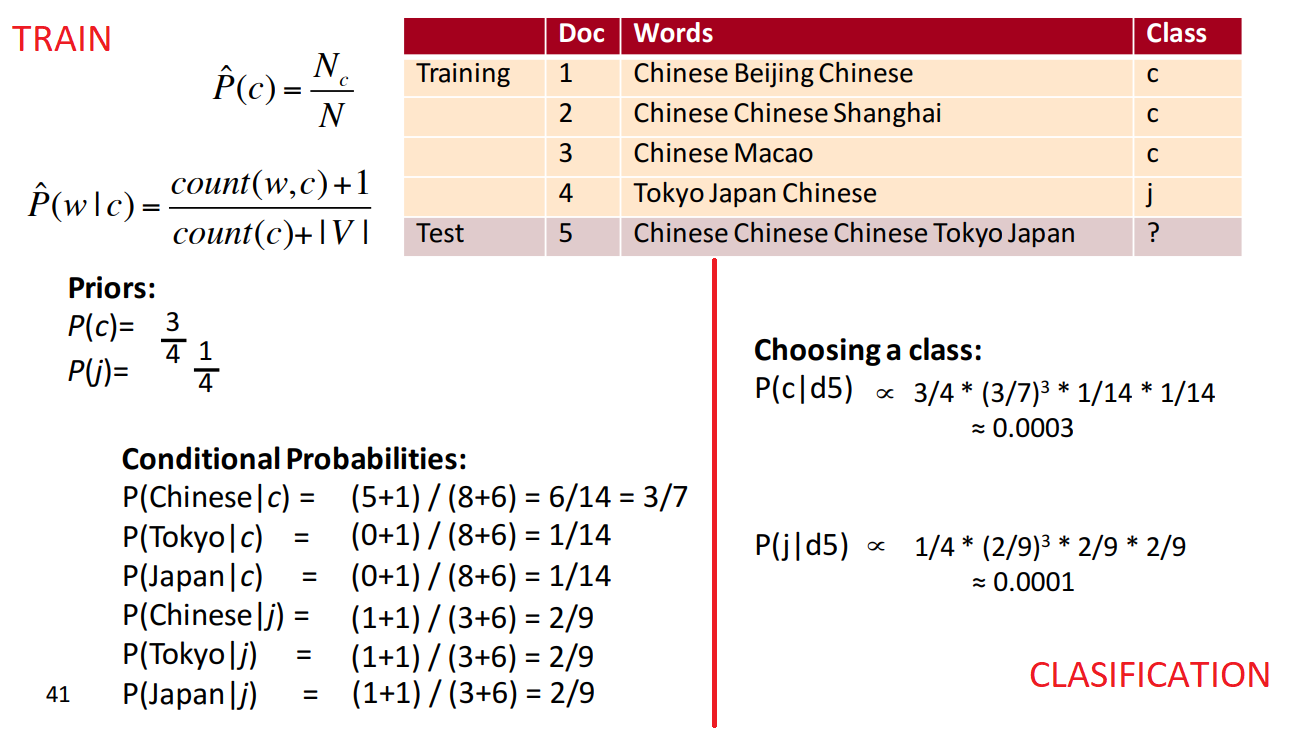

Notar que la probabilidad para los casos de ejemplo vendrian dada por:

$$P(c|d5) = \dfrac{0.0003}{0.003+0.0001} = 0.75$$

$$P(j|d5) = \dfrac{0.0001}{0.003+0.0001} = 0.25$$

------------------------
#### Creemos el clasificador 🧪

**Primero, definimos el pipeline**

In [14]:
# Definimos el vectorizador para convertir el texto a BoW:
vectorizer = CountVectorizer()  

# Definimos el clasificador que usaremos.
clf = MultinomialNB()   

# Creamos el pipeline
text_clf = Pipeline([('vect', vectorizer), # Paso 1 del pipeline
                     ('clf', clf)]         # Paso 2 del pipeline
                    )

**Luego, lo entrenamos**

In [41]:
X_train

1522    5 tristes ejemplos que muestran lo grave que s...
835     Cancillería informa que de momento no hay víct...
358     Senado argentino inicia discusión en comisione...
138     Empresarios por bajo Imacec: "No hay que habla...
299     EEUU elogia postura de Bolsonaro sobre program...
                              ...                        
4426    CPLT llama a "modernización de la ley" tras ci...
466     Opositores en Nicaragua alistan nuevas protest...
3092    PDI indaga ataque armado en Lautaro: encapucha...
3772    Vecinas de Quintero-Puchuncaví por indagación ...
860     Irán calificó como "ilegales" sanciones de EEU...
Name: content, Length: 3350, dtype: object

In [15]:
# Entrenamos nuestro pipeline
text_clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('clf', MultinomialNB())])

**Y predecimos**

In [16]:
y_pred = text_clf.predict(X_test)

**Veamos como nos fue:**


In [17]:
# algunos ejemplos:
pd.DataFrame({'content': X_test, 'category':y_test, 'predicted category': y_pred}).sample(5)

,content,category,predicted category
756,Errores en Indonesia: Agencia de Catástrofes d...,asia,asia
328,Excomandante de la aviación cercano a Chávez d...,america-latina,america-latina
3928,Incendio deja tres viviendas completamente des...,region-de-valparaiso,region-de-valparaiso
1047,Fraude en el Ejército: SML revisará si dueña d...,chile,chile
2399,Francia anuncia investigación nacional tras el...,europa,mediooriente


In [18]:
# usando la matriz de confusión:

# eje x -> predichos
# eje y -> clase real

# 0 -> ee uu
# 1 -> animales
print(confusion_matrix(y_test, y_pred))

[[68  1  0  0  7  1  1  0  1  1  0 10  0  0  0  0  0  0  4  0]
 [ 0 70  2  5  0  2  4  2  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1 59  6  0 11  2  0  0  1  0  0  0  0  0  0  0  0  0 10]
 [ 0  1  1 54  0  2  4  3  0  2  4  0  0  0  0  0  0  0  0  1]
 [ 3  7  0  0 59  2  4  0 11  1  1  0  1  0  0  0  4  2  1  0]
 [ 1  1  1  4  0 54  7  1  0  0  1  0  0  0  0  0  0  0  0  7]
 [ 0  2  3  2  0 27 41  4  0  4  1  0  0  0  0  0  0  0  0  8]
 [ 0  5  0  4  0  3  3 51  0  0 11  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  2  0  0 73  0  1  1  0  0  0  0  0  2  2  0]
 [ 1  3  0  7  0  4  1  2  0 63  4  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  3  0  0  2  2  0  2 67  0  0  0  0  0  0  0  0  0]
 [12  0  0  2  7  7  1  1  1  0  0 42  0  0  0  0  0  0 10  0]
 [ 1  4  1  0 11  2  1  0  1  0  0  2 36  5  2  2  6 10  3  0]
 [ 3  1  0  0  2  1  0  0  0  0  0  2  0 58  2  0  1  3  0  0]
 [ 0  0  0  0  3  1  2  0  1  0  0  3  0  6 54  0  3  6  1  0]
 [ 2  1  0  0  6  3  0  0  0  0  0  2  0  5  0 47  3 15

#### Métricas de Evaluación

Las métricas definen un puntaje de evaluación que indica que tal le fue al sistema. Hay muchas formas distintas de medir su rendimiento. Entre estas, tenemos:

- `precision`: El número de documentos de una clase clasificados correctamente dividido por el número de documentos totales clasificados como esa clase. Precision es una buena medida para determinar, cuando los costes de los falsos positivos son altos.

- `recall`: El número de documentos de una clase clasificados correctamente dividido por el número de los documentos que se deberían haber clasificado como esa clase (número de documentos reales de esa clase). Lo utilizamos cuando tiene un alto coste la detección falsos negativos.

- `f1-score` : Es la media armónica entre los anteriores.

- `accuracy` : La cantidad de documentos clasificados correctamente versus todos los documentos

Por otra parte, tenemos dos formas de ver dichas métricas agrupadas:

- `Macroaveraging`:    Se computan las métricas por cada clase y luego de promedia.

- `Microaveraging`:    Se recolectan las clasificaciones por cada clase, se computa la tabla de contingencia (todos los elementos clasificados) y se evalua. Representa un Macroaveraging ponderado por el número de miembros de una clase.

In [19]:
# usando el classification report:
print(classification_report(y_test, y_pred))

                        precision    recall  f1-score   support

  actualidad-economica       0.67      0.72      0.69        94
        america-latina       0.70      0.82      0.76        85
              animales       0.86      0.66      0.74        90
                  asia       0.60      0.75      0.67        72
                 chile       0.56      0.61      0.58        96
          curiosidades       0.34      0.70      0.46        77
                debate       0.43      0.45      0.44        92
                  eeuu       0.77      0.66      0.71        77
           entrevistas       0.81      0.89      0.85        82
                europa       0.85      0.74      0.79        85
          mediooriente       0.74      0.87      0.80        77
   negocios-y-empresas       0.55      0.51      0.53        83
region-de-la-araucania       0.95      0.41      0.58        87
   region-de-los-lagos       0.74      0.79      0.77        73
    region-de-los-rios       0.90      

#### Ejecutemos algunas consultas!

In [20]:
text_clf.predict([
    ("En puerto montt se encontró un perrito, que aparentemente,"
    "habría consumido drogas de alto calibre. Producto de esto,"
    "se ponostíca que padecerá severa caña durante varios dias.")
])

array(['region-de-los-lagos'], dtype='<U22')

In [21]:
text_clf.predict(["kim jong un será el próximo candidato a ministro de educación."])

array(['asia'], dtype='<U22')

In [22]:
text_clf.predict([("El banco mundial presentó para chile un decrecimiento"
                   "económico de 92% y una inflación de 8239832983289%.")])

array(['actualidad-economica'], dtype='<U22')

-------------------------

Se ven bastante buenos los resultados. ¿Pero, podremos mejorarlos?

### Preprocesamiento del texto

En clases vimos que habían varias técnicas que permiter preprocesar los textos.
Es decir, cómo hacemos el proceso de tokenización (separación de las palabras).



Alguna de las técnicas son:


- Eliminación de Stopwords
- Stemming
- Lematización

Existen otros preprocesadores que agregan información a las oraciones, tales como aquellos que indican negaciones.

A continuación, describiremos con mas detalle cada uno de estas técnicas.

#### Tokenizar ➗

¿Qué era tokenizar?


Es el proceso de convertir una secuencia de carácteres (por ejemplo, una oración) en una secuencia de valores distintos entre si llamados tokens.
    
Referencia: [Tokenización en wikipedia](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization)



**spaCy y el objeto nlp**

`nlp` es el objeto que nos permite usar e interactuar con la librería [`spacy`](https://spacy.io/).
Esta librería incluye variadas herramientras, tales como tokenizar, lematizar, descartar stopwords, entre otras (para este auxiliar, solo utilizaremos las mencionadas). El objeto nlp lo instanciamos en la sección de imports.

Para usarla, simplemente se le pasa el texto como parámetro, como veremos en el siguiente ejemplo: 

In [23]:
DOC = "hermanito mio te estay pegando el manso show"

tokens = []
for word in nlp(DOC):
    tokens.append(word)

tokens

[hermanito, mio, te, estay, pegando, el, manso, show]

**Observación**: Para este auxiliar usaremos `List Comprehension`, otra forma de hacer un for un poco mas reducida.
Una muy buena referencia de esto [aquí](https://www.programiz.com/python-programming/list-comprehension).

La operación anterior usando esta sintáxis quedaría como:

In [24]:
tokens = [word for word in nlp(DOC)]
tokens

[hermanito, mio, te, estay, pegando, el, manso, show]

#### Stopwords 🛑

¿Qué eran las stopwords?

Las Stopwords son palabras muy comunes en nuestro lenguaje y que por lo tanto, no aportan mucha información. Existen múltiples listas de stopwords para muchos idiomas y la aplicación de estas variará caso a caso.

    
Referencias: [Stopwords en Wikipedia](https://en.wikipedia.org/wiki/Stop_words)

En este caso, utilizaremos las stopwords inlcuidas en la librería spaCy en español

In [25]:
print(len(STOP_WORDS))
print(list(STOP_WORDS)[0:20])

551
['explicó', 'cinco', 'cuatro', 'temprano', 'podrán', 'podriais', 'primeros', 'teneis', 'mismo', 'esos', 'va', 'dias', 'van', 'sus', 'conseguir', 'dijeron', 'próximos', 'hacemos', 'esas', 'propias']


#### Stemming 🔪

¿Qué era el stemming? 

Son un conjunto de métodos enfocados en reducir cada palabra a su raiz. De cierta manera se parece a la lematización, pero los resultados (las raíces) no tienen por qué ser palabras de un idioma.

Referencia: [Stemming en Wikipedia](https://en.wikipedia.org/wiki/Stemming)
  
**Ejemplos: **


| word | stem of the word  |
|---|---|
working | work
worked | work
works | work

**nltk**

En este caso, utilizaremos la segunda librería de herramientas de nlp: [`nltk`](https://www.nltk.org/). Esta provee una buena herramienta para hacer stemming en español : `SnowballStemmer`

In [26]:
stemmer = SnowballStemmer('spanish')
stemmed_doc = [stemmer.stem(str(token)) for token in tokens]
print(stemmed_doc)

['hermanit', 'mio', 'te', 'estay', 'peg', 'el', 'mans', 'show']


#### Lematización 🙀

¿Qué era lematización? 

Es el proceso de transformar cada token a su lema, el cual es la palabra base sin ningún tipo de flexión o alteración como las conjugaciones. El lema no es otra cosa que la forma que tienen las palabras cuando las buscas en el diccionario.
    
    

  
    
    
Referencia: [Lematización en wikipedia](https://en.wikipedia.org/wiki/Lemmatisation)

Refernecia: [Flexión en las palabras](https://es.wikipedia.org/wiki/Flexi%C3%B3n_(ling%C3%BC%C3%ADstica))

**Ejemplos**

| word | lemma  |
|---|---|
dije| decir 
guapas | guapo
mesitas | mesa
 

**Lematizar el texto**

Al igual que la tokenización, utilizaremos `scpaCy` (a través del objeto `nlp`) para lematizar el contenido.

In [27]:
lemmatized_content = [word.lemma_ for word in nlp(DOC)]
print(lemmatized_content)

['hermanito', 'mio', 'te', 'estay', 'pegar', 'el', 'manso', 'show']



**Discusión:**

    ¿Cuál es mejor?

### Sistema de clasificación con preprocesamiento

Para agregar los tokenizadores en el sistema, creamos funciones que que cada documento de forma individual usando nuestro preprocesador favorito. Luego, `CountVectorizer` se encargará de usar estas funciones sobre todo el dataset.

#### Tokenizadores para CountVectorizer

In [28]:
# Tokenizers para CountVectorizer

# Solo tokenizar el doc usando spacy.
def tokenizer(doc):
    return [x.orth_ for x in nlp(doc)]

# Tokenizar y remover las stopwords del doc
def tokenizer_with_stopwords(doc):
    return [x.orth_ for x in nlp(doc) if x.orth_ not in STOP_WORDS]

# Tokenizar y lematizar.
def tokenizer_with_lemmatization(doc):
    return [x.lemma_ for x in nlp(doc)]

# Tokenizar y hacer stemming.
def tokenizer_with_stemming(doc):
    stemmer = SnowballStemmer('spanish')
    return [stemmer.stem(word) for word in [x.orth_ for x in nlp(doc)]]

#### Creamos nuestro clasificador


**Definimos el pipeline**




In [29]:
# seleccionamos el tokenizador a usar:
TOKENIZER = tokenizer

# Definimos el vectorizador para convertir el texto a BoW:
vectorizer = CountVectorizer(analyzer='word',
                             tokenizer=TOKENIZER,
                             ngram_range=(1, 1))

# Definimos el clasificador que usaremos.
clf = MultinomialNB()   

# Creamos el pipeline
text_clf_2 = Pipeline([('vect', vectorizer), ('clf', clf)])

**Entrenamos nuestro pipeline y predecimos**


In [30]:
text_clf_2.fit(X_train, y_train)
y_pred = text_clf_2.predict(X_test)

**Evaluamos**

In [31]:
# usando la matriz de confusión:
print(confusion_matrix(y_test, y_pred))

[[67  0  0  0  7  3  0  0  1  0  0 10  0  0  0  0  0  0  6  0]
 [ 1 68  1  5  0  1  5  2  0  1  0  1  0  0  0  0  0  0  0  0]
 [ 0  1 60  6  0  9  3  0  0  1  0  0  0  0  0  0  0  0  0 10]
 [ 0  1  1 53  0  1  4  4  0  2  5  0  0  0  0  0  0  0  0  1]
 [ 3  7  0  0 57  2  3  1 12  0  1  2  1  0  0  0  1  2  4  0]
 [ 0  1  2  2  0 52 10  0  0  0  1  0  0  0  0  0  0  0  2  7]
 [ 0  1  2  2  0 22 45  5  0  5  1  0  0  0  0  0  0  0  0  9]
 [ 0  8  0  4  0  3  3 52  0  0  7  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  2  0  0 73  0  1  1  0  0  0  0  0  2  2  0]
 [ 0  4  0  8  0  3  2  1  0 64  3  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  3  0  1  2  1  0  3 66  0  0  0  0  0  0  0  0  0]
 [ 8  0  0  1  9  5  1  1  2  0  0 45  0  0  0  0  0  0 11  0]
 [ 0  1  1  0 10  2  0  0  1  0  0  3 40  7  1  3  7  9  2  0]
 [ 4  1  0  0  1  1  0  0  0  0  0  0  0 57  1  1  1  5  1  0]
 [ 0  1  0  0  5  1  1  0  1  0  0  2  0  5 53  0  7  3  1  0]
 [ 1  0  0  0  4  3  0  0  0  0  0  3  0  4  1 53  2 13

In [32]:
# usando el classification report:
print(classification_report(y_test, y_pred))

                        precision    recall  f1-score   support

  actualidad-economica       0.71      0.71      0.71        94
        america-latina       0.70      0.80      0.75        85
              animales       0.86      0.67      0.75        90
                  asia       0.61      0.74      0.67        72
                 chile       0.53      0.59      0.56        96
          curiosidades       0.36      0.68      0.47        77
                debate       0.43      0.49      0.46        92
                  eeuu       0.76      0.68      0.72        77
           entrevistas       0.78      0.89      0.83        82
                europa       0.84      0.75      0.80        85
          mediooriente       0.78      0.86      0.81        77
   negocios-y-empresas       0.54      0.54      0.54        83
region-de-la-araucania       0.95      0.46      0.62        87
   region-de-los-lagos       0.76      0.78      0.77        73
    region-de-los-rios       0.91      

#### Pregunta abierta: ¿Por qué no mejoran los resultados?

[Aquí](https://www.quora.com/Is-it-normal-to-get-better-accuracy-without-stemming-and-lemmatization-than-using-them-in-NLP-text-classification) hay una muy buena discusión al respecto.

### Clasificación usando Regresión Logísitica

No profundizaremos en este clasificador, mas del hecho de que se "supone" que debería tener mejor rendimiento que el de bayes.

Referencia: [Regresión Logística](https://en.wikipedia.org/wiki/Logistic_regression)

**Definimos nuestro Pipeline**

In [33]:
# Qué tokenizer usaremos?
TOKENIZER = tokenizer_with_lemmatization

# Definimos el vectorizador para convertir el texto a BoW:
vectorizer = CountVectorizer(analyzer='word',
                             tokenizer=TOKENIZER,
                             ngram_range=(1, 1))

# Ahora definimos regresión logística como clasificador.
log_mod = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter = 1000)   
log_pipe = Pipeline([('vect', vectorizer), ('clf', log_mod)])

**Entrenamos y predecimos**

In [34]:
log_pipe.fit(X_train, y_train)
y_pred = log_pipe.predict(X_test)

**Evaluamos**

In [35]:
# usando la matriz de confusión:
print(confusion_matrix(y_test, y_pred))

[[67  0  0  0  3  3  1  0  1  0  0 11  0  0  0  0  3  0  5  0]
 [ 1 66  2  4  1  0  4  4  0  3  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 72  3  0  2  3  0  0  1  0  0  0  0  0  0  0  0  0  9]
 [ 0  1  1 60  0  2  1  1  0  0  3  0  0  0  0  1  0  0  0  2]
 [ 7  0  0  1 59  1  2  0  6  0  0  1  4  0  1  2  1  6  4  1]
 [ 0  1  3  5  0 37 12  3  0  1  0  0  0  0  0  0  0  1  3 11]
 [ 0  0  6  4  0 13 50  5  0  5  1  1  0  0  0  0  0  0  0  7]
 [ 0  4  0  9  0  1  3 50  0  0  9  0  0  0  0  0  0  0  0  1]
 [ 0  1  0  0  0  0  0  0 78  0  0  2  0  0  0  0  0  1  0  0]
 [ 1  1  0  5  0  0  1  2  0 71  1  0  0  0  0  0  0  2  0  1]
 [ 0  3  0  3  0  0  3  5  0  2 60  0  1  0  0  0  0  0  0  0]
 [10  0  0  0 10  2  0  1  0  0  0 39  1  0  0  1  3  4 10  2]
 [ 0  0  0  0  2  0  0  0  0  0  0  1 82  0  1  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1 67  1  0  2  2  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  2 74  0  1  1  0  1]
 [ 0  0  0  0  1  1  0  0  1  0  0  4  1  2  0 69  1  5

In [36]:
# usando el classification report:
print(classification_report(y_test, y_pred))

                        precision    recall  f1-score   support

  actualidad-economica       0.67      0.71      0.69        94
        america-latina       0.85      0.78      0.81        85
              animales       0.80      0.80      0.80        90
                  asia       0.63      0.83      0.72        72
                 chile       0.71      0.61      0.66        96
          curiosidades       0.49      0.48      0.48        77
                debate       0.56      0.54      0.55        92
                  eeuu       0.69      0.65      0.67        77
           entrevistas       0.90      0.95      0.92        82
                europa       0.86      0.84      0.85        85
          mediooriente       0.81      0.78      0.79        77
   negocios-y-empresas       0.57      0.47      0.51        83
region-de-la-araucania       0.88      0.94      0.91        87
   region-de-los-lagos       0.92      0.92      0.92        73
    region-de-los-rios       0.94      

### N-gramas

Los n-gramas son conjuntos de n-tokens seguidos entre si. La idea de usar esto es que además, capturemos conceptos. 

Por ejemplo, si usamos 2-gramas sobre `'Hoy día comí lentejas'`, esta quedaría como:


```python
['hoy dia', 'día comí', 'comí lentejas']
```

`CountVectorizer` tiene la opción para poner n-gramas del tamaño que tu quieras, y además incluir mas pequeños. Todo esto se define en el parámetro `ngram_range`. Este recibe una tupla con los rangos del n-grama mas pequeño y el mas grande. Por ejemplo, para (1,2), la oración anterior quedaría: 


```python
['hoy', 'día', 'comí', 'lentejas', 'hoy dia', 'día comí', 'comí lentejas']
```

Nota que esto incrementa el tamaño de los vectores de Bag of words y por lo tanto, del entrenamiento y de la predicción. 

In [37]:
# Qué tokenizer usaremos?
TOKENIZER = tokenizer_with_lemmatization

# Definimos el vectorizador para convertir el texto a BoW:
vectorizer = CountVectorizer(analyzer='word',
                             tokenizer=TOKENIZER,
                             ngram_range=(1, 3))

# Ahora definimos regresión logística como clasificador.
log_mod = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter = 1000)   
log_pipe = Pipeline([('vect', vectorizer), ('clf', log_mod)])

**Entrenamos y predecimos**

In [38]:
log_pipe.fit(X_train, y_train)
y_pred = log_pipe.predict(X_test)

**Evaluamos**

In [39]:
# usando la matriz de confusión:
print(confusion_matrix(y_test, y_pred))

[[65  0  0  0  6  2  0  0  2  0  0 11  0  0  1  0  3  0  4  0]
 [ 0 66  2  5  2  0  3  3  0  3  0  1  0  0  0  0  0  0  0  0]
 [ 0  0 70  5  0  0  0  0  0  1  0  0  0  0  0  0  0  2  0 12]
 [ 0  1  1 61  0  1  1  1  0  2  2  0  0  0  0  0  0  0  0  2]
 [ 5  0  0  0 64  2  2  1  5  0  0  2  4  0  1  2  1  5  2  0]
 [ 0  1  3  5  0 41 11  3  0  1  0  0  0  0  0  0  0  0  3  9]
 [ 1  1  6  4  1 13 47  4  0  4  2  1  0  0  0  0  0  0  0  8]
 [ 0  3  0  7  0  1  2 56  0  0  8  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0 79  0  0  2  0  0  0  0  0  0  0  0]
 [ 1  0  0  8  0  0  1  3  0 68  2  0  0  0  0  0  1  0  0  1]
 [ 0  2  0  4  0  0  2  3  0  2 64  0  0  0  0  0  0  0  0  0]
 [ 8  0  0  0  7  2  0  1  0  0  0 45  1  0  0  3  3  2 10  1]
 [ 0  0  0  0  1  0  0  0  0  0  0  2 82  0  1  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0 69  1  1  1  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  1 76  0  1  0  0  1]
 [ 0  0  0  0  1  1  0  0  1  0  0  3  2  2  1 69  1  4

In [40]:
# usando el classification report:
print(classification_report(y_test, y_pred))

                        precision    recall  f1-score   support

  actualidad-economica       0.71      0.69      0.70        94
        america-latina       0.87      0.78      0.82        85
              animales       0.79      0.78      0.78        90
                  asia       0.61      0.85      0.71        72
                 chile       0.73      0.67      0.70        96
          curiosidades       0.55      0.53      0.54        77
                debate       0.63      0.51      0.56        92
                  eeuu       0.75      0.73      0.74        77
           entrevistas       0.90      0.96      0.93        82
                europa       0.84      0.80      0.82        85
          mediooriente       0.82      0.83      0.83        77
   negocios-y-empresas       0.54      0.54      0.54        83
region-de-la-araucania       0.90      0.94      0.92        87
   region-de-los-lagos       0.92      0.95      0.93        73
    region-de-los-rios       0.93      

## Créditos

Todas las noticias extraidas perteneces a [Biobio Chile](https://www.biobiochile.cl/), los cuales gentilmente licencian todo su material a través de la [licencia Creative Commons (CC-BY-NC)](https://creativecommons.org/licenses/by-nc/2.0/cl/)

## Referencias

Gitgub del curso: 
- https://github.com/dccuchile/CC6205

Slides:
- https://web.stanford.edu/~jurafsky/slp3/slides/7_NB.pdf


Análisis de sentimientos como clasificación de texto:
- https://affectivetweets.cms.waikato.ac.nz/benchmark/

Algunos Recursos útiles
- [Pandas Cheat Sheet](https://pandas.pydata.org/Pandas_Cheat_Sheet.pdf)
- [Scikit-learn Cheat Sheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Scikit_Learn_Cheat_Sheet_Python.pdf)
- [Spacy Tutorial](https://www.datacamp.com/community/blog/spacy-cheatsheet)
- [NLTK Cheat sheet](http://sapir.psych.wisc.edu/programming_for_psychologists/cheat_sheets/Text-Analysis-with-NLTK-Cheatsheet.pdf)